In [ ]:
!pip install rasterio numpy geopandas


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.5/21.5 MB 37.2 MB/s eta 0:00:00


2
The image shape is (600, 600)
The reference coordinate system is EPSG:4326
The image transform is | 0.01, 0.00, 71.00|
| 0.00,-0.01, 33.00|
| 0.00, 0.00, 1.00|
The image bounds are BoundingBox(left=71.0, bottom=30.0, right=74.0, top=33.0)


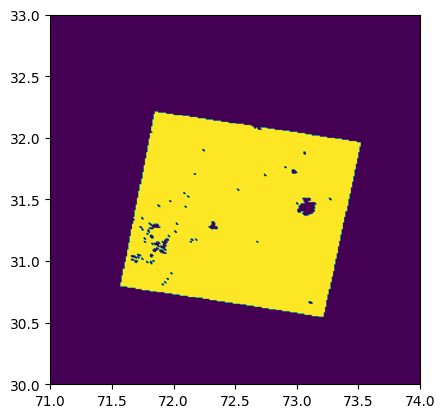

Soil moisture value at (72, 31.5): 0.02869768999516964
Maximum Soil Moisture: 0.47927621006965637


In [ ]:
import rasterio
from rasterio.plot import show
from rasterio.transform import rowcol
import numpy as np

# Path to the SAR image
image_path = "/content/drive/MyDrive/Geospatial Images/E04_SAR_MRS_08JAN2024_008011226575_10478_STGCSMHTD_13251_09_D_R_073_031_M1_500m.tif"


# geographic coordinates (longitude, latitude)
lon, lat = (72, 31.5)

img = rasterio.open(image_path)
print(img.count)
print('The image shape is {}'.format(img.shape))
print('The reference coordinate system is {}'.format(img.crs))
print('The image transform is {}'.format(img.transform))
print('The image bounds are {}'.format(img.bounds))
show(img)

with rasterio.open(image_path) as src:
    # Reading the image data assuming the soil moisture product is in the first band
    image_data = src.read(1)

    # image transform
    transform = src.transform

    # geographic coordinates to pixel coordinates
    row, col = rowcol(transform, lon, lat)

    # if the pixel coordinates are within the image bounds
    if 0 <= row < image_data.shape[0] and 0 <= col < image_data.shape[1]:
        # Extracting the soil moisture value at the given pixel coordinates
        soil_moisture_value = image_data[row, col]
        print(f'Soil moisture value at ({lon}, {lat}): {soil_moisture_value}')
    else:
        print("The provided coordinates are outside the image bounds.")

print('Maximum Soil Moisture: {}'.format(np.max(image_data)))

In [ ]:
!pip install netCDF4

<class 'netCDF4._netCDF4.Dataset'>
root group (NETCDF4 data model, file format HDF5):
    source: ucar_cu_cygnss_sm_v1_2023_275.nc
    id: PODAAC-CYGNU-L3SM1
    ShortName: CYGNSS_L3_SOIL_MOISTURE_V1.0
    title: CYGNSS Level 3 Soil Moisture from UCAR/CU
    summary: The CYGNSS Level 3 Soil Moisture Product provides volumetric water content estimates for soils between 0-5 cm depth at a 6-hour discretization for most of the subtropics. The data were produced by CYGNSS investigators at the University Corporation for Atmospheric Research (UCAR) and the University Colorado at Boulder (CU), and derive from version 2.1 of the CYGNSS L1 SDR. The soil moisture algorithm uses collocated soil moisture retrievals from SMAP to calibrate CYGNSS observations from the same day. For a given location, a linear relationship between the SMAP soil moisture and CYGNSS reflectivity is determined and used to transform the CYGNSS observations into soil moisture. The data are archived in daily files in netCDF-

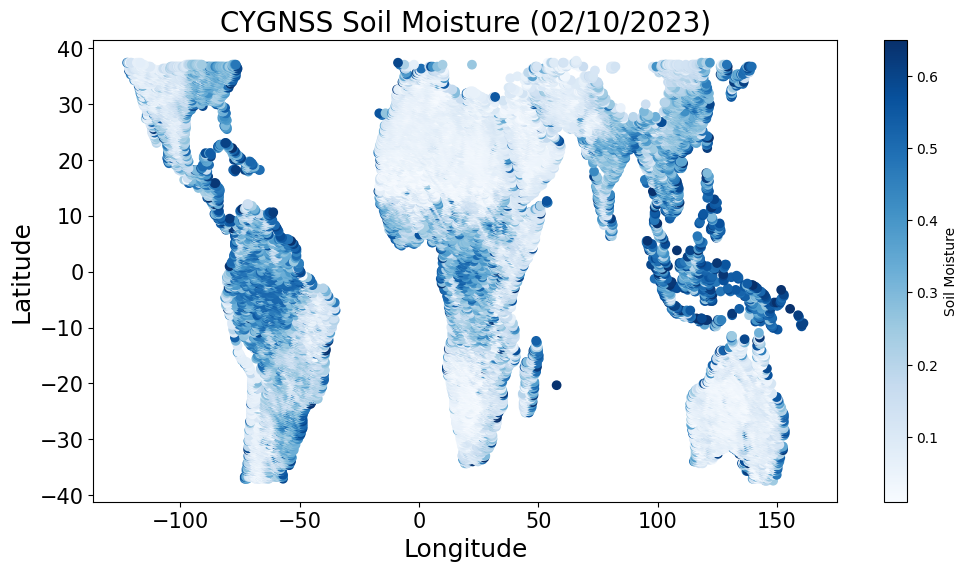

In [ ]:
import netCDF4 as nc
import numpy as np
import matplotlib.pyplot as plt

# File path to the CYGNSS NetCDF data
file = '/content/drive/MyDrive/CYGNSS_L3_SOIL_MOISTURE_V1.0_1.0-20240724_111557/ucar_cu_cygnss_sm_v1_2023_275.nc'
with nc.Dataset(file, 'r') as ds:
      # Assuming the soil moisture data is stored in a variable named 'soil_moisture'
      soil_moisture = ds.variables['SM_daily'][:]
      latitudes = ds.variables['latitude'][:]
      longitudes = ds.variables['longitude'][:]
      print(ds)


# Visualizing the soil moisture data
plt.figure(figsize=(12, 6))
plt.scatter(longitudes, latitudes, c=soil_moisture, cmap='Blues')
plt.colorbar(label='Soil Moisture')
plt.xlabel('Longitude', fontsize=18)
plt.ylabel('Latitude', fontsize=18)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.title('CYGNSS Soil Moisture (02/10/2023)', fontsize=20)
plt.show()


**Extracting CYGNSS Data**

In [ ]:
import os
import glob
import netCDF4 as nc
import numpy as np
import csv

# Function to extract and calculate the average soil moisture value for a specific region
def calculate_average_sm(file_path, lat_min, lon_min, lat_max, lon_max):
    with nc.Dataset(file_path, 'r') as ds:
        soil_moisture = ds.variables['SM_daily'][:]
        latitudes = ds.variables['latitude'][:]
        longitudes = ds.variables['longitude'][:]

        # Extracting the date of observation
        date = ds.time_coverage_start[0:10]

        soil_moisture_values = []
        for i in range(latitudes.shape[0]):
            for j in range(longitudes.shape[1]):
                if (lat_min <= latitudes[i, j] <= lat_max) and (lon_min <= longitudes[i, j] <= lon_max) and soil_moisture[0, i, j] != '--':
                    soil_moisture_values.append(soil_moisture[0, i, j])

        if soil_moisture_values:
            average_sm = np.mean(soil_moisture_values)
        else:
            average_sm = np.nan  # In case no values are found in the specified region
    return date, average_sm

# Directory containing the NetCDF files
directory = '/content/drive/MyDrive/CYGNSS_L3_SOIL_MOISTURE_V1.0_1.0-20240724_111557'
pattern = '*.nc'  # Pattern to match NetCDF files

# Latitude and longitude bounds
lat_min = 26
lon_min = 83
lat_max = 27
lon_max = 84

# List to store the results
results = []

# Iterating over all NetCDF files in the directory
for filepath in glob.glob(os.path.join(directory, pattern)):
    date, average_sm = calculate_average_sm(filepath, lat_min, lon_min, lat_max, lon_max)
    results.append([os.path.basename(filepath), date, average_sm])

# Saving the results to a CSV file
csv_file = '/content/drive/MyDrive/Geospatial Images/average_soil_moisture.csv'
with open(csv_file, mode='w', newline='') as file:
    writer = csv.writer(file)
    writer.writerow(['File', 'Date', 'Average_SM'])
    writer.writerows(results)

print(f'Results saved to {csv_file}')


Results saved to /content/drive/MyDrive/Geospatial Images/average_soil_moisture.csv


In [ ]:
!pip install h5py numpy matplotlib

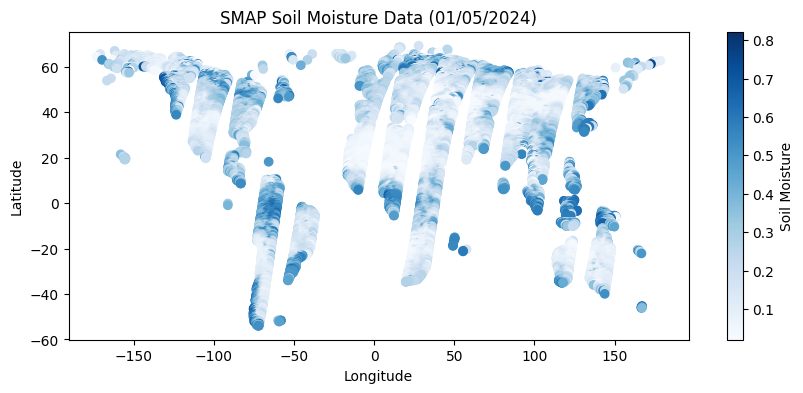

2024-05-01


In [ ]:
import h5py
import numpy as np
import matplotlib.pyplot as plt

file_path = '/content/drive/MyDrive/Geospatial Images/SMAP/SMAP_L3_SM_P_20240501_R19240_001.h5'
fill_value = -9999
with h5py.File(file_path, 'r') as f:

        # since the datasets are named as such'
        soil_moisture = f['Soil_Moisture_Retrieval_Data_AM/soil_moisture'][:]
        soil_moisture[soil_moisture == fill_value] = np.nan
        latitudes = f['Soil_Moisture_Retrieval_Data_AM/latitude_centroid'][:]
        longitudes = f['Soil_Moisture_Retrieval_Data_AM/longitude_centroid'][:]
        date  =f['Metadata/Extent'].attrs['rangeBeginningDateTime'][0:10]
# Visualizing the soil moisture data
plt.figure(figsize=(10, 4))
plt.scatter(longitudes, latitudes, c=soil_moisture, cmap='Blues')
plt.colorbar(label='Soil Moisture')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('SMAP Soil Moisture Data (01/05/2024)')
plt.show()
print(date)


In [ ]:
import h5py
import numpy as np
import matplotlib.pyplot as plt

file_path = '/content/drive/MyDrive/Geospatial Images/SMAP/SMAP_L3_SM_P_20240501_R19240_001.h5'

lat_min = 27
lon_min = 83
lat_max = 28
lon_max = 84

with h5py.File(file_path, 'r') as f:

        # since the datasets are named as such'
        soil_moisture = f['Soil_Moisture_Retrieval_Data_AM/soil_moisture'][:]
        latitudes = f['Soil_Moisture_Retrieval_Data_AM/latitude_centroid'][:]
        longitudes = f['Soil_Moisture_Retrieval_Data_AM/longitude_centroid'][:]

soil_moisture_values = []
for i in range(latitudes.shape[0]):
      for j in range(longitudes.shape[1]):
          if (lat_min<=latitudes[i,j]<=lat_max) and (lon_min<=longitudes[i,j]<=lon_max) and soil_moisture[i, j] != '-9999':
               soil_moisture_values.append(soil_moisture[i, j])
print("The average SM_daily value in the area is: ", np.mean(soil_moisture_values))



The average SM_daily value in the area is:  0.17299077


In [ ]:
!pip install earthengine-api


**Extracting SMAP Data**

In [ ]:
import ee
import pandas as pd

# Authenticating and initialize the Earth Engine API
ee.Authenticate()
ee.Initialize()

# Date range and bounding coordinates
start_date = '2023-10-01'
end_date = '2024-06-30'
min_lat = 26.0
max_lat = 27.0
min_lon = 83.0
max_lon = 84.0

# Polygon geometry from the bounding coordinates
region_of_interest = ee.Geometry.Polygon([
    [[min_lon, min_lat], [min_lon, max_lat], [max_lon, max_lat], [max_lon, min_lat], [min_lon, min_lat]]
])

# SMAP Level 3 soil moisture data
smap = ee.ImageCollection("NASA/SMAP/SPL3SMP_E/006").filterDate(start_date, end_date).select('soil_moisture_am')

# Function to extract soil moisture for each image
def extract_soil_moisture(image):
    date = image.date().format('YYYY-MM-dd')
    soil_moisture = image.reduceRegion(
        reducer=ee.Reducer.mean(),
        geometry=region_of_interest,
        scale=9000
    ).get('soil_moisture_am')

    return ee.Feature(None, {'date': date, 'soil_moisture': soil_moisture})

# Applying the function to each image in the collection
soil_moisture_collection = smap.map(extract_soil_moisture)

# Converting the collection to a FeatureCollection
soil_moisture_fc = ee.FeatureCollection(soil_moisture_collection)

# Exporting the FeatureCollection to a CSV file in Google Drive
export_task = ee.batch.Export.table.toDrive(
    collection=soil_moisture_fc,
    description='SoilMoistureExport',
    fileFormat='CSV'
)

# Export task
export_task.start()

print('Export task started. Check your Google Drive for the CSV file.')


Export task started. Check your Google Drive for the CSV file.


In [ ]:
!pip install pydrive
!pip install zipfile36

In [ ]:
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

# Authenticating and creating the PyDrive client.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

**Creating TIF Files Directory**

In [ ]:
import os
import shutil
import zipfile

parent_folder_id = '1ghTcN6JDa90SU7ZWRewsE_FcOYnirvZM'

# Creating a new folder for .tif files
folder_name = "TIF_Files"
folder_metadata = {
    'title': folder_name,
    'mimeType': 'application/vnd.google-apps.folder',
    'parents': [{'id': parent_folder_id}]
}
folder = drive.CreateFile(folder_metadata)
folder.Upload()
new_folder_id = folder['id']
print(f"Created new folder with ID: {new_folder_id}")

# Files in the parent folder and filter for ZIP files with correct MIME type
file_list = drive.ListFile({'q': f"'{parent_folder_id}' in parents and trashed=false"}).GetList()
zip_files = [file for file in file_list if file['mimeType'] == 'application/x-zip-compressed']

print(f"Found {len(zip_files)} ZIP files")

# Ensuring 'extracted' directory exists
extraction_path = '/content/extracted'
if not os.path.exists(extraction_path):
    os.makedirs(extraction_path)

for zip_file in zip_files:
    zip_file_name = zip_file['title']
    print(f"Downloading ZIP file: {zip_file_name}")
    zip_file.GetContentFile(zip_file_name)

    # Extracting the ZIP file
    with zipfile.ZipFile(zip_file_name, 'r') as zip_ref:
        zip_ref.extractall(extraction_path)
        print(f"Extracted {zip_file_name} to {extraction_path}")

    # Removing the ZIP file after extraction
    os.remove(zip_file_name)

    # Finding .tif files
    tif_files_found = False
    for root, dirs, files in os.walk(extraction_path):
        for file in files:
            if file.endswith('.tif'):
                tif_files_found = True
                tif_file_path = os.path.join(root, file)
                print(f"Uploading .tif file: {tif_file_path}")
                new_tif_file = drive.CreateFile({'title': file, 'parents': [{'id': new_folder_id}]})
                new_tif_file.SetContentFile(tif_file_path)
                new_tif_file.Upload()
                print(f"Uploaded {file} to new folder")

    if not tif_files_found:
        print("No .tif files found in the extracted content")

    # Cleaning up extracted files and directories
    shutil.rmtree(extraction_path)
    os.makedirs(extraction_path)
print("Script completed.")


Created new folder with ID: 1RDtw4B54yPFkQapbrzKwm2IxayQk9lE8
Found 76 ZIP files
Extracted E04_SAR_MRS_02MAY2024_123002248417_12216_STGCSMHTD_15581_05_D_R_084_028_00_500m.zip to /content/extracted
Uploading .tif file: /content/extracted/E04_SAR_MRS_02MAY2024_123002248417_12216_STGCSMHTD_15581_05_D_R_084_028_00_500m/E04_SAR_MRS_02MAY2024_123002248417_12216_STGCSMHTD_15581_05_D_R_084_028_00_500m.tif
Uploaded E04_SAR_MRS_02MAY2024_123002248417_12216_STGCSMHTD_15581_05_D_R_084_028_00_500m.tif to new folder
Extracted E04_SAR_MRS_03MAR2024_063002851885_11309_STGCSMHTD_14380_09_D_R_083_026_M1_500m.zip to /content/extracted
Uploading .tif file: /content/extracted/E04_SAR_MRS_03MAR2024_063002851885_11309_STGCSMHTD_14380_09_D_R_083_026_M1_500m/E04_SAR_MRS_03MAR2024_063002851885_11309_STGCSMHTD_14380_09_D_R_083_026_M1_500m.tif
Uploaded E04_SAR_MRS_03MAR2024_063002851885_11309_STGCSMHTD_14380_09_D_R_083_026_M1_500m.tif to new folder
Extracted E04_SAR_MRS_13JUN2024_165002838340_12851_STGCSMHTD_1657

**Extracting SAR Data**

In [ ]:
import os
import rasterio
from rasterio.transform import rowcol
import numpy as np
import pandas as pd
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

# Bounding box (in geographic coordinates: lon_min, lon_max, lat_min, lat_max)
bbox = (83, 84, 26, 27)
lon_min, lon_max, lat_min, lat_max = bbox

# Google Drive folder ID containing the TIFF files
parent_folder_id = '1RDtw4B54yPFkQapbrzKwm2IxayQk9lE8'

# New folder for results
results_folder_name = "Average_Soil_Moisture_Results"
results_folder_metadata = {
    'title': results_folder_name,
    'mimeType': 'application/vnd.google-apps.folder',
    'parents': [{'id': parent_folder_id}]
}
results_folder = drive.CreateFile(results_folder_metadata)
results_folder.Upload()
results_folder_id = results_folder['id']
print(f"Created results folder with ID: {results_folder_id}")

# TIFF files in the parent folder
file_list = drive.ListFile({'q': f"'{parent_folder_id}' in parents and trashed=false"}).GetList()
tif_files = [file for file in file_list if file['mimeType'] == 'image/tiff']

# Initializing the results list
results = []

# Processing each TIFF file
for tif_file in tif_files:
    tif_file_name = tif_file['title']
    tif_file_id = tif_file['id']
    date_str = tif_file_name.split('_')[3]

    # Downloading the TIFF file
    print(f"Downloading TIFF file: {tif_file_name}")
    downloaded_file_path = f'/content/{tif_file_name}'
    tif_file.GetContentFile(downloaded_file_path)

    # Processing the TIFF file
    with rasterio.open(downloaded_file_path) as src:
        # Image data
        image_data = src.read(1)
        transform = src.transform

        # Converting bounding box coordinates to pixel coordinates
        row_min, col_min = rowcol(transform, lon_min, lat_max)
        row_max, col_max = rowcol(transform, lon_max, lat_min)

        # Ensuring pixel coordinates are within bounds
        row_min, row_max = int(max(0, row_min)), int(min(image_data.shape[0], row_max))
        col_min, col_max = int(max(0, col_min)), int(min(image_data.shape[1], col_max))

        # Extracting the subarray within the bounding box
        subarray = image_data[row_min:row_max, col_min:col_max]

         # Masking the fill value (-9999) and calculate the average soil moisture value
        valid_data = subarray[subarray != -9999]
        if valid_data.size > 0:
            avg_soil_moisture = np.mean(valid_data)
        else:
            avg_soil_moisture = np.nan  # No valid data available

        results.append({'Date': date_str, 'Average Soil Moisture': avg_soil_moisture})

    # Removing the downloaded TIFF file
    os.remove(downloaded_file_path)

# Results CSV
results_df = pd.DataFrame(results)
results_csv_path = '/content/average_soil_moisture_results.csv'
results_df.to_csv(results_csv_path, index=False)
print(f"Results saved to {results_csv_path}")

# Uploading CSV file to Google Drive
uploaded_results_file = drive.CreateFile({'title': 'average_soil_moisture_results.csv', 'parents': [{'id': results_folder_id}]})
uploaded_results_file.SetContentFile(results_csv_path)
uploaded_results_file.Upload()
print(f"CSV file uploaded to Google Drive folder with ID: {results_folder_id}")

Created results folder with ID: 1Bg7RSl4zyHyHCNvLw6uCdEa5LjHD06Pb
Results saved to /content/average_soil_moisture_results.csv
CSV file uploaded to Google Drive folder with ID: 1Bg7RSl4zyHyHCNvLw6uCdEa5LjHD06Pb
